# Import libraries

In [6]:
from math import *
from sympy import *
from ipywidgets import *
from IPython.display import display,clear_output
import numpy as np
import matplotlib.pyplot as plt

# Styling

In [7]:
%%html
<style>
textarea, input {
    font-family: Cambria Math;
    text-align: center;
}
:root {
    --jp-ui-font-size1: 16px;
}
</style>

In [8]:
CSS = """
.output {
    font-family: Cambria Math;
    display: flex;
    align-items: center;
    align-content: center
    justify-content:center;
    text-align: center;
    flex-wrap:nowrap;
}
.widget-label {
description_width': 'initial';
}

-button{
    background-color: #689e5f
}

.widget-radio-box {
        flex-direction: row !important;
    }
 .widget-radio-box label{
        width: 'initial';
    }    
"""

HTML('<style>{}</style>'.format(CSS))


HTML(value="<style>\n.output {\n    font-family: Cambria Math;\n    display: flex;\n    align-items: center;\n…

# Input processing and algorithms

In [9]:
#Parse input string to the right format
def get_func(s):
    import re
    # step1: trim all whitespaces
    s = re.sub(r'\s+',"",s).replace('e**','e^')
    #step2: convert e^() to exp(), e^__ to exp(x), ln__ to ln()
    s = re.sub(r"[e]\^\((\w*)",r"exp(\1",s) 
    s = re.sub('e\^([0-9a-z.]*)','exp(\g<1>)',s) 
    s = re.sub(r"ln([0-9a-z.()]*)",r'ln(\g<1>)',s) 
    #step3.1: add * between 2 consecutive alphabetical characters | a digit and an alphabetical character
    s = re.sub('(?i)(?<=[a-z0-9])(?=[a-z])',r'*',s) 
    #step3.2: add * between an alphabetical character and a digit
    s = re.sub('(?i)(?<=[a-z])(?=[0-9])',r'*',s) 
    #step3.3 add * between number and open bracket
    s = re.sub('(?<=[a-z0-9])(?=[([{])',r'*',s)
    #step3.4 add * between closing bracket and number or open bracket, fix error from step3
    s = re.sub('(?:(?<=[)])|(?<=[}])|(?<=[]]))(?:(?=([a-z0-9]))|(?=[({[]))',r'*',s)
    s = s.replace("l*n*","ln").replace("l*o*g*","log").replace("t*a*n*","tan").replace("c*o*s*","cos").replace("s*i*n*","sin").replace("e*x*p*","exp").replace("^","**").replace('−','-')
    return s
#Return the implicit solution for linear ode, and exact solution if exact=True
def ode_linear(p_x,q_x,exact=False,x0=None,y0=None):    
    x,y,C = symbols('x y C')  
    P_x = integrate(p_x,x)
    implicit = f"exp(-({P_x}))*({integrate(f'exp({P_x})*({q_x})')}+C)"
    if exact:
        f = sympify(f'{implicit}-y')
        explicit = implicit.replace('C',f'{solve(f.subs(x,x0).subs(y,y0),C)[0]}')
        return str(simplify(expand(explicit)))
    else:
        return str(simplify(expand(implicit)))
    
def extract(s):
    import re
    q_x = re.search('(?<=\=)(.*)',s).group(1)
    if re.search('(?<=y\'[+-])(.*)(?=\=)',s):
        p_x = re.search('(?<=y\')(.*)(?=\=)',s).group(0).strip()
    else:
        p_x = re.search('(.*)(?=[+]y\')',s).group(0).strip() 
    
    p_x = '-1' if p_x=='-y' else '1' if p_x=='y' else get_func(p_x.replace('y',"*1")) if p_x[-1]=='y' else get_func(p_x.replace('y',"1*")) if p_x[0]=='y' else get_func(p_x.replace('y',"*1*")) 
    
    q_x =  get_func(re.search('(?<=\=)(.*)',s).group(1))
    return str(simplify(expand(p_x))),str(simplify(expand(q_x)))
def ode_euler(f,x0,y0,x,h=0.01,record=False):
    dx = lambda x,y: eval(f)
    if record:
        list_x,list_y=[],[]
        if x<x0:
            while(x0>x):
                list_x.append(x0)
                list_y.append(y0)
                y0 -= h*dx(x0,y0)
                x0 -= h
                
        else:
            while(x0<x):
                list_x.append(x0)
                list_y.append(y0)
                y0 += h*dx(x0,y0)
                x0 += h
        return y0,list_x,list_y
    else: 
        if x<x0:
            while(x0>x):
                y0 -= h*dx(x0,y0)
                x0 -= h
        else:
            while(x0<x):
                y0 += h*dx(x0,y0)
                x0 += h
        return y0

# Plotting

GridspecLayout(children=(Label(value="$y' + p(x) y = q(x)$", layout=Layout(grid_area='widget001')), Text(value…

Button(description='Compute', layout=Layout(width='auto'), style=ButtonStyle(button_color='lightgreen'), toolt…

AppLayout(children=(VBox(children=(HBox(children=(Label(value='Exact solution:'), Label(value='$2 + e^{- x^{3}…

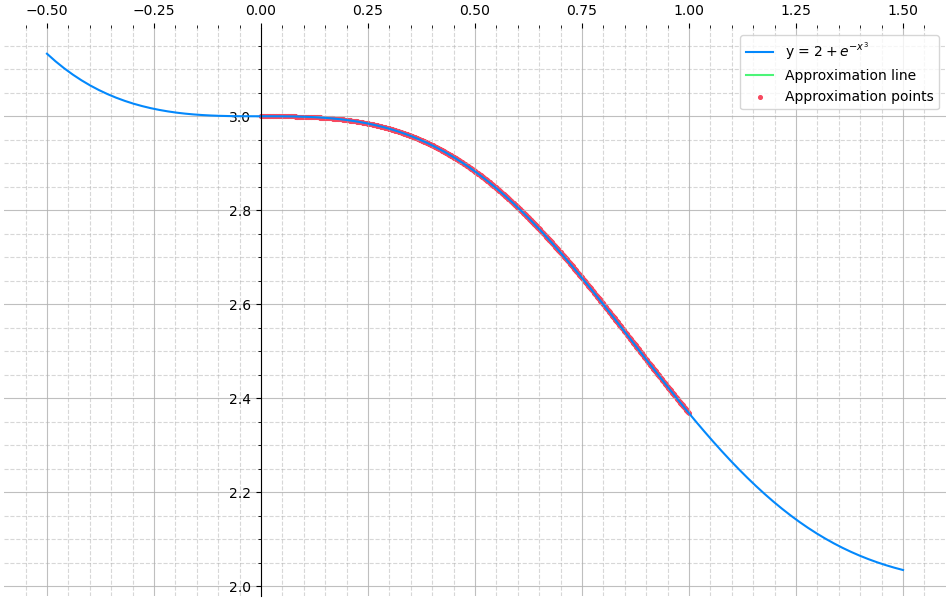

In [10]:
%matplotlib widget
#create UI
ode_sample = widgets.Label(value="$y' + p(x) y = q(x)$")
ode_expr = widgets.Text(value="y' + 3x^2y = 6x^2",placeholder="Linear differential equation",layout={'width': '280px'})
init_x0 = widgets.Text(value="0",placeholder="x0",description='y(',style={'description_width': 'initial'},layout=Layout(flex='0.1 1 20%', width='20px'))
init_y0 = widgets.Text(value="3",description=')=',placeholder="y0",style={'description_width': 'initial'},layout=Layout(flex='0.1 0.5 60%', width='10px'))
radio_h = widgets.RadioButtons(options=[0.1, 0.01, 0.001],description='Step size 𝒉:',style={'description_width': 'initial'},layout={'width': 'max-content'},disabled=False)
y_approx = widgets.Text(value="1",placeholder="?",style={'description_width': 'initial'},layout={'width': '90%'})
checkbox_h = widgets.Checkbox(description="custom 𝒉",value=False,indent=False,layout=Layout(flex='1 1 10%',justify_content="flex-start"))
custom_h = widgets.Text(value="",placeholder="𝒉 value",disabled=True,layout=Layout(width="200px"))
button_compute = widgets.Button(description='Compute',layout={'width': 'auto'},tooltip = "Cook math",style = dict(button_color = 'lightgreen'))
exact_label = widgets.Label(value="Exact solution:")
exact_expr = widgets.Text(value="",layout={'width': 'initial'})
exact_solution = widgets.Label(value="Lorem ipsum",layout={'width': 'initial'})
res_exact = widgets.Text(value="",description="Exact y =",layout={'width': 'initial'})
res_approx = widgets.Text(value="",description="Approx. y≈",layout={'width': 'initial'})
res_error = widgets.Text(value="",description="Error %",layout={'width': 'auto'})
checkbox_line = widgets.Checkbox(indent=True,value=False,description="Show line")
checkbox_dots = widgets.Checkbox(indent=False,value=True,description="Show dots")
grid_input = GridspecLayout(5, 3,width="960px",height='initial')
grid_input[0,0] = ode_sample
grid_input[1,0] = ode_expr
grid_input[0,1] = widgets.Label(value='Initial value')
grid_input[1,1] = widgets.HBox([init_x0,init_y0])
grid_input[3,1] = radio_h
grid_input[4:,1] = widgets.HBox([checkbox_h,custom_h])
grid_input[0,2] = widgets.Label(value='Approximate for y(?)')
grid_input[1,2] = y_approx

result = AppLayout(header=None,
          left_sidebar=widgets.VBox([widgets.HBox([exact_label,exact_solution]),exact_expr]),
          center=widgets.VBox([res_approx,res_exact]),
          right_sidebar=widgets.VBox([res_error,widgets.HBox([checkbox_line,checkbox_dots])]),
          footer=None,
          pane_widths=[2.5, 3, 3], 
          pane_heights=[0,5,0],
          grid_gap="30px")
fig,line,list_x,list_y,dots = None,None,None,None,None
#Event handlers
def show_line(change):
    if change.new:
        line.set_data(list_x,list_y)
        fig.canvas.draw()
    else:
        line.set_data([],[])
        fig.canvas.draw()
def show_dots(change):
    if change.new:
        dots.set_visible(True)
        fig.canvas.draw()
    else:
        dots.set_visible(False)
        fig.canvas.draw()
def custom(change):
    if change.new:
        custom_h.disabled=False
        radio_h.disabled=True
    else:
        custom_h.disabled=True
        radio_h.disabled=False
checkbox_h.observe(custom,'value')    
def compute(event):    
        clear_output(wait=False)
        try:
            global fig,line,list_x,list_y,dots
            res_exact.value,res_approx.value,res_error.value="","",""
            display(grid_input)
            display(button_compute)
            p_x,q_x = extract(get_func(ode_expr.value))
            solution_y = ode_linear(p_x,q_x,exact=True,x0=eval(init_x0.value),y0=eval(init_y0.value))  if init_x0.value and init_y0.value else  ode_linear(p_x,q_x)   
            exact_solution.value = f"${latex(sympify(solution_y))}$"
            exact_expr.value = solution_y
            if init_x0.value and init_y0.value and y_approx.value:
                x0 = eval(init_x0.value)
                y0 = eval(init_y0.value)
                x = eval(y_approx.value)           
                stepsize = eval(custom_h.value) if checkbox_h.value and custom_h.value else radio_h.value
                checkbox_line.disabled=True if stepsize<0.001 else False
                val,list_x,list_y = ode_euler(f'({q_x})-({p_x})*y',x0,y0,x,h=stepsize,record=True)       
                res_exact.value = f"{round(eval(solution_y),6)}" 
                res_approx.value = f"{round(val,6)}"
            if res_exact.value and res_approx.value: 
                res_error.value = f'{round(100*abs(eval(res_exact.value)-eval(res_approx.value))/abs(eval(res_exact.value)),4)} %'
            display(result)
            if res_error.value:
                fig,ax = plt.subplots(constrained_layout=True, figsize=(9.5,6))
                fig.canvas.toolbar_position = 'bottom'
                fig.canvas.header_visible = False
                f = lambda x: eval(solution_y)
                ax.plot([i for i in np.linspace(x0-0.5,x+0.5,100)],[f(i) for i in np.linspace(x0-0.5,x+0.5,100)],label=f"y = ${latex(sympify(solution_y))}$",color="#0388fc")
                ax.spines['bottom'].set_position(('data',0))
                ax.spines['right'].set_color('none')
                ax.spines['top'].set_color('none')
                ax.xaxis.set_ticks_position('top')
                ax.yaxis.set_ticks_position('left')
                ax.spines['left'].set_position(('data',0)) 
                ax.minorticks_on()
                ax.grid(visible=True, which='major', axis='both', alpha=0.8)
                ax.grid(visible=True, which='minor', axis='both', alpha=0.5,linestyle='dashed')
                ax.autoscale(enable=True, axis='both', tight=None)   
                if not checkbox_line.disabled:
                    line,= ax.plot([],[],color='#4cf578',label='Approximation line')
                dots = ax.scatter(list_x,list_y,color='#f7485f',s=7,label="Approximation points")
                dots.set_visible(False)
                if checkbox_dots.value:
                    dots.set_visible(True) 
                ax.legend(loc=1, prop={'size': 10}) 
        except:
            clear_output(wait=True)
            display(grid_input)
            display(button_compute)
            display('CANNOT COMPUTE')
checkbox_line.observe(show_line,'value')
checkbox_dots.observe(show_dots,'value')
button_compute.on_click(compute)
display(grid_input)
display(button_compute)
